# LSTM and BiLSTM



By the end of this lab, you will be able to:

- Explain how LSTM networks solve long-term dependency problems

- Understand the structure and advantages of Bidirectional LSTMs

- Build a word-based text generation model using BiLSTM

- Understand the motivation behind contextual embeddings

- Use ELMo embeddings, which are built on deep BiLSTMs

## Part 1 — Long Short-Term Memory (LSTM)

The Problem with **Vanilla RNNs**

Traditional RNNs try to learn patterns in sequences (text, audio, time series).
But they **struggle** with:
- Vanishing gradients
- Difficulty learning long-range dependencies
- Forgetting earlier context

LSTMs fix RNN limitations by adding a memory cell and gates:

- **Forget Gate**-> Decides what old information to remove.

- **Input Gate**-> Decides what new information to store.

- **Output Gate** -> Decides what part of the memory to output.

- **Cell State** -> The model’s long-term memory “highway”.

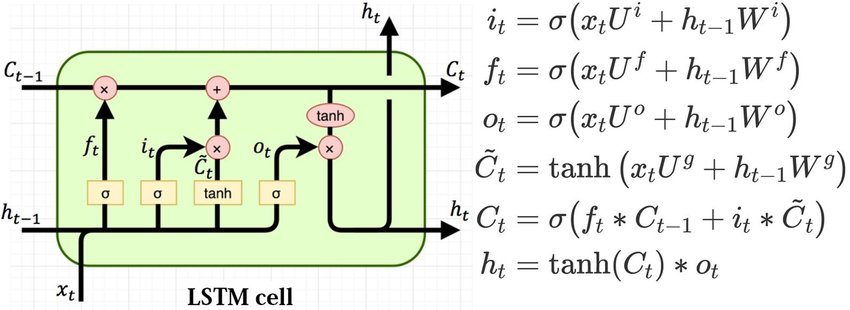

## Part 2 — Bidirectional LSTM (BiLSTM)

A normal LSTM reads text only **left → right.**

BiLSTM = two LSTMs working together:

- Forward LSTM → reads sentence left → right

- Backward LSTM → reads sentence right → left

Output = concatenation of both
This provides richer context.

In the following task, we will train a BiLSTM on the BBC News Dataset to generate new text word by word.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [ ]:
url = "/content/IMDB Dataset.csv"
df = pd.read_csv(url)

In [ ]:
corpus = " ".join(df['review'][:100].astype(str).tolist())

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([corpus])
total_words = len(tokenizer.word_index) + 1

tokens = tokenizer.texts_to_sequences([corpus])[0]

In [ ]:
# Create sequence
input_sequences = []
for i in range(3, len(tokens)):
    seq = tokens[i-3:i+1]
    input_sequences.append(seq)

input_sequences = np.array(input_sequences)
X = input_sequences[:, :-1]
y = tf.keras.utils.to_categorical(input_sequences[:, -1], num_classes=total_words)

In [ ]:
model = Sequential([
    Embedding(total_words, 128, input_length=3),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=10, batch_size=16)

Epoch 1/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.0595 - loss: 7.1461
Epoch 2/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0803 - loss: 6.3436
Epoch 3/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1044 - loss: 5.9195
Epoch 4/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.1252 - loss: 5.5089
Epoch 5/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1543 - loss: 5.0878
Epoch 6/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1814 - loss: 4.7125
Epoch 7/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2214 - loss: 4.2694
Epoch 8/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2677 - loss: 3.8246
Epoch 9/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3217 - loss: 3.3724
Epoch 10/10
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3766 - loss: 2.9740


In [ ]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_text(seed_text, next_words=20, temperature=1.0):
    for _ in range(next_words):
        seq = tokenizer.texts_to_sequences([seed_text])[0]
        seq = pad_sequences([seq], maxlen=3, truncating='pre')

        preds = model.predict(seq, verbose=0)[0]

        predicted_id = sample_with_temperature(preds, temperature)

        predicted_word = tokenizer.index_word.get(predicted_id, "")

        seed_text += " " + predicted_word

    return seed_text

In [ ]:
print(generate_text("the movie was", temperature=0.3))

the movie was not a good actress but it is not a good scene not boring in the little characters and the movie


## Lab practise Task 1:
- Build a word-level next-word prediction model using a BiLSTM.

- Train it on your text corpus.

- Implement a generate_text() function.

- Add a temperature parameter (as explained in the previous lab) to control randomness:

  - Low temperature → more predictable, repetitive output

  - High temperature → more creative, less predictable output

# ELMo: Embeddings from Language Models

Old word embeddings **(Word2Vec, GloVe)** assign **one vector per wor**d, regardless of context.

**ELMo** introduces contextualized word embeddings, meaning:

- The embedding changes depending on sentence meaning

- It uses a large pretrained language model

- It uses 2 stacked Bidirectional LSTMs (very important)

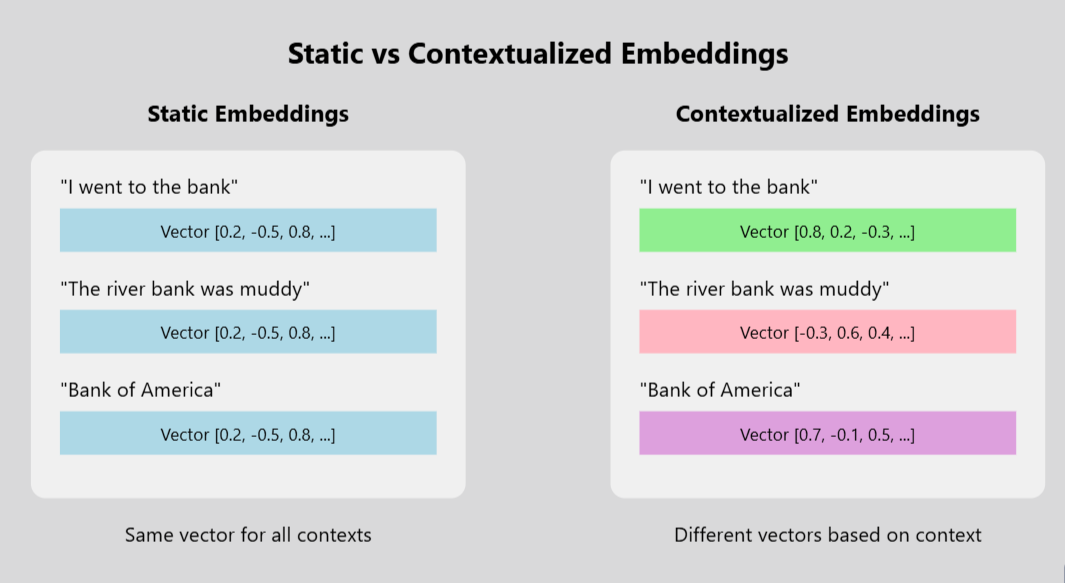

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [ ]:
def get_elmo_embeddings(sentence):
    embeddings = elmo.signatures["default"](tf.constant([sentence]))
    return embeddings["elmo"][0]


In [ ]:
sent1 = "The bat flew across the night sky"
sent2 = "He hit the ball with a wooden bat"


emb1 = get_elmo_embeddings(sent1)
emb2 = get_elmo_embeddings(sent2)


In [ ]:
tokens1 = sent1.split()
tokens2 = sent2.split()

idx1 = tokens1.index("bat")
idx2 = tokens2.index("bat")

In [ ]:
vec1 = emb1[idx1].numpy()
vec2 = emb2[idx2].numpy()

In [ ]:
print("Sentence 1 word:", tokens1[idx1])
print("Sentence 2 word:", tokens2[idx2])

print("\nFirst 10 dims of 'bat' embedding (sky):\n", vec1[:10])
print("\nFirst 10 dims of 'bat' embedding (wooden):\n", vec2[:10])

Sentence 1 word: bat
Sentence 2 word: bat

First 10 dims of 'bat' embedding (sky):
 [-0.45903698 -0.2751642  -0.26348162 -0.12380224 -0.11530858 -0.4588077
 -0.12675601 -0.12455767 -0.26304623 -0.18395609]

First 10 dims of 'bat' embedding (wooden):
 [-0.257378   -0.1887329   0.04546601 -0.31656295 -0.12787223  0.03929149
 -0.02446625  0.39564455  0.13283803 -0.22623408]


## Lab practice:


- Choose two sentences that contain the multiple shared words but with different meanings.
- Extract the ELMo embedding for each word in both sentences.
- Print the embeddings of the shared word from both sentences.